### Import Packages

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from functools import reduce
from cvxopt import matrix
from cvxopt.solvers import qp, options,lp
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBClassifier
from functools import reduce
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.stats import norm
import tkinter.messagebox
import tkinter as tk
from tkinter import ttk
from tkinter.font import Font

### Input Functions

In [2]:
# Function to get and read input file:
def read_file(file):
    df=pd.read_excel(file,sheet_name='Adj Close')
    df_return=pd.read_excel(file,sheet_name='Return')
    df['Date']=pd.to_datetime(df['Date'])
    df_return['Date']=pd.to_datetime(df_return['Date'])
    df=df.set_index('Date').sort_index(ascending=True).dropna()
    df_return=df_return.set_index('Date').sort_index(ascending=True).dropna()
    return df,df_return
 
# Function to calculate arithmetric average:
def arithmetric_avg(df):
    [timeN,assetN]=df.shape
    arithmetric_avg=[]
    for i in range(assetN):
        arithmetric_avg.append(float(df.iloc[:,i].mean()*12))
    arithmetric_avg=np.array(arithmetric_avg)
    return float(np.mean(arithmetric_avg))

# Function to calculate gometric average:
def geometric_avg(df,var):
    [timeN,assetN]=df.shape
    geometric_avg=[]
    for i in range(assetN):
        a=np.array(df.iloc[:,i]+1)
        pord=np.prod(a)
        b=float(-1+pord**(1/len(a)))
        geometric_avg.append(b)
    geometric_avg=np.array(geometric_avg)
    if var==0:
        return geometric_avg
    elif var==1:
        return 12*float(np.mean(geometric_avg))

# Calculate asset class covariance:
def cov_matrix(df1,df2,df3,df4):
    index=df1.index
    df1=df1.mean(1).to_frame()
    df2=df2.mean(1).to_frame()
    df3=df3.mean(1).to_frame()
    df4=df4.mean(1).to_frame()
    df=pd.concat([df1,df2,df3,df4],axis=1)
    cov=df.cov().values
    return cov

# Calculate volatility:
def vol(weight,cov):
    return float(np.sqrt(reduce(np.dot, [weight, cov, weight.T])))

# Develop a linear regression model to predict asset class returns:
def linreg(returns,factRet):
    [time,factor] = factRet.shape
    [time,asset] = returns.shape
    
    colName=list(factRet.columns)
    f_bar=factRet.tail(2).mean()
    f_bar=pd.DataFrame(f_bar).T
    f_bar.columns=colName    

    factRet=factRet.head(len(factRet)-1)
    
    mu=[]
    model = LinearRegression()
    # Fit the gradient boosting model:
    for i in range(asset):
        model.fit(factRet, returns.iloc[:,i])
        mu.append(float(model.predict(f_bar)))
    mu=np.array(mu)
    cov = np.array(returns.cov())
    
    return mu,cov

# Develop an optimized distributed gradient boosting model to predict asset class returns:
def xgboost(returns,factRet):
    [time,factor] = factRet.shape
    [time,asset] = returns.shape
    
    colName=list(factRet.columns)
    f_bar=factRet.tail(2).mean()
    f_bar=pd.DataFrame(f_bar).T
    f_bar.columns=colName    

    factRet=factRet.head(len(factRet)-1)
    
    # Machine learning process (parameter tuning):
    xgb = XGBClassifier(learning_rate=0.1,n_estimators=10,
                                max_depth=7,min_child_weight=2,
                                gamma=0.2,subsample=0.8,
                                colsample_bytree=0.6,objective='reg:linear',
                                scale_pos_weight=1,seed=10) 
    mu=[]
    
    # Fit the gradient boosting model:
    for i in range(asset):
        xgb.fit(factRet,returns.iloc[:,i])
        mu.append(float(xgb.predict(f_bar)))
    mu=np.array(mu)
    cov = np.array(returns.cov())
    
    return mu,cov

# Function to find portfolio with maximum Sharpe Ratio:
def max_sharpe_r(ret,cov,rf,lb,ub):
    # Input matrix:
    lb=np.array(lb)
    ub=np.array(ub)
    n=len(ret)
    P=matrix(cov)
    q=matrix(np.zeros((n, 1)))
    G=np.zeros((2*n,n))
    for i in range(n):
        j=2*i
        G[j,i]=-1
        G[j+1,i]=1
    G=matrix(G)

    h=np.zeros((2*n, 1))
    for i in range(n):
        h[2*i]=-1*lb[i]
        h[2*i+1]=ub[i]
    h=matrix(h)
    a=np.ones((1,n))
    A=matrix(np.vstack((a,ret)))
    
    r_given = []
    risk = []
    weight=[]    
    
    # Everytime when return increase 0.0001 from its minimum value to its maximu value, find the respective
    # minimum portfolio variance 
    for temp_r in np.arange(max(min(ret),0),max(ret),0.0001):
        try:
            b=matrix(np.array([[1],[temp_r]]))
            options['show_progress'] = False
            options['maxiters']=1000
            outcome = qp(P,q,G,h,A,b)
            x=np.array(outcome['x'])           
            
            if outcome['status']!='optimal':
                continue
            r_given.append(temp_r)
            risk.append(vol(x.T,cov))
            
            weight.append(x.round(4))
        except:
            pass        
    sharpe_r=(np.array(r_given)-rf)/np.array(risk)
    return weight[sharpe_r.argmax()]

# Portfolio optimization function:
def portfolio_opt(asset_ret,cov,lb,ub,ret_scale):
    
    # Optimization input matrix
    lb=np.array(lb)
    ub=np.array(ub)
    n=len(asset_ret)
    P=matrix(cov)
    q=matrix(np.zeros((n, 1)))
    G=np.zeros((2*n,n))
    for i in range(n):
        j=2*i
        G[j,i]=-1
        G[j+1,i]=1
    G=matrix(G)

    h=np.zeros((2*n, 1))
    for i in range(n):
        h[2*i]=-1*lb[i]
        h[2*i+1]=ub[i]
    h=matrix(h)
    a=np.ones((1,n))
    A=matrix(np.vstack((a,asset_ret)))

    ret = []
    risk = []
    weight=[]    
    for temp_r in np.arange(max(min(asset_ret),0),max(asset_ret),0.0001):
        try:
            b=matrix(np.array([[1],[temp_r]]))
            options['show_progress'] = False
            options['maxiters']=1000
            outcome = qp(P,q,G,h,A,b)
            x=np.array(outcome['x'])           
            
            if outcome['status']!='optimal':
                continue
            ret.append(temp_r)
            risk.append(vol(x.T,cov))
            
            weight.append(x.round(4))
        except:
            pass     
    index=int(round(ret_scale*len(ret),0))
    return np.array(weight[index])

# Function for optimizing CVaR        
def cvar_opt(df,rf,var):
    inf=np.inf
    alpha=0.95
    ret=geometric_avg(df,var)
    r_given=[]
    weight=[]
    cvar=[]
    for temp_r in np.arange(max(0,min(ret)),max(ret),0.0001):
        timeNum,assetNum=df.shape
        lb=np.concatenate((0*np.ones([1,assetNum]),np.zeros([1,timeNum]),0*np.ones([1,1])),axis=1).T
        bound=[]
        for i in range(len(lb)):
            temp_bound=(float(lb[i]),None)
            bound.append(temp_bound)
        
        a=np.concatenate((-df.values,-np.eye(timeNum),-np.ones([timeNum,1])),axis=1)
        b=np.concatenate((np.reshape(-ret,[1,len(ret)]),np.zeros([1,timeNum]),np.zeros([1,1])),axis=1)
        A = np.concatenate((a,b),axis=0)
        
        b=np.concatenate((np.zeros([timeNum,1]),temp_r*np.ones([1,1])),axis=0)
        
        Aeq=np.concatenate((np.ones([1,assetNum]),np.zeros([1,timeNum+1])),axis=1)
        beq=np.ones([1,1])
        
        k=1/((1-alpha)*timeNum)
        c=np.concatenate((np.zeros([assetNum,1]),k*np.ones([timeNum,1]),np.ones([1,1])),axis=0)
        
        outcomes=linprog(c, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq,bounds=bound)
        if outcomes.success==True:
            weight.append(np.round(outcomes.x[0:assetNum],4))
            r_given.append(temp_r)
            cvar.append(round(float(outcomes.fun),4))
    if len(np.unique(cvar))==1:
        return weight[0]
    else:
        return weight[np.argmin(cvar)]

# Calculate VaR of simulated portfolio returns:
def var_calc(asset_ret, weight):
    asset_ticker = list(asset_ret.columns)
    
    n=asset_ret.shape[1]
    composition = weight

    def sim_return(historical_returns, forecast_days):
        return historical_returns.sample(n = forecast_days,replace = True).reset_index(drop = True)
    
    # Using bootstrap sampling:   
    def sim_portfolio(historical_returns, composition, forecast_days):
        result = 0
        for t in range(n):
            try:
                weight = composition[t]
            except:
                weight=composition
            name = asset_ticker[t]
            sim_ret = sim_return(historical_returns[name], forecast_days)
            result = result + sim_ret * weight
        return(result)
    
    VaR=[]
    for i in range(100):
        simu_return = sim_portfolio(asset_ret,composition,6)
        sort_return = simu_return.sort_values(ascending=True)
        sort_return.reset_index(drop = "true")
        
        confidence_level=0.99
        threshold=int(len(asset_ret)*(1-confidence_level))
        var = sort_return.iloc[threshold]
        VaR.append(var)
    return (round(100*np.mean(VaR),2))

def var_calc_norm(mu, Q, weight):
    n=len(weight)
    result = 0
    critical=norm.ppf(0.99)
    for t in range(n):
        result = result + weight[t] * (mu[t] + critical*float(Q[t,t]))
    return result

# Scenario tests of different asset classes under Global Financial Crisis:
# Equity
def test_gfc_equity(w_e,value_p,equity_drop): 
    gfc_e=[]
    for i in range(len(w_e)):
        gfc_e.append(float(w_e[i] * equity_drop.iloc[i]))
    gfc_e_drop = pd.DataFrame(gfc_e).iloc[:,0].sum() * value_p
    return float(gfc_e_drop)

# Fixed Income
def test_gfc_fi(w_f,value_f):
    gfc_f_drop = (w_f[0] * (0.048268) + w_f[1] * (-0.1522268)) * value_f
    return float(gfc_f_drop)

# Private Equity
def test_gfc_pe(w_pe,value_pe):
    gfc_pe_drop = w_pe * value_pe * (-0.4638)
    return float(gfc_pe_drop)

# Real Estate
def test_gfc_real(w_r,value_r):
    gfc_r_drop = (w_r[0] * (-0.53183924) + w_r[1] * (-0.208404905)) * value_r      
    return float(gfc_r_drop)    

# Scenario tests for different asset classes under sharply increasing interest rate:
# Equity
def test_ir_equity(equity,equityPr,w,spx):  
    ir=[]
    for i in range(equity.shape[1]):
        df=pd.concat([equity.iloc[:,i],spx],axis=1)
        beta = df.cov().values[0,1] / np.var(spx.values)
        ir.append( w[i] * beta * (-0.07) * equityPr[i])
    return float(sum(ir))

# Fixed Income
def test_ir_fi(fix,fixPr,w,spx):
    ir=[]
    for i in range(fix.shape[1]):
        df=pd.concat([fix.iloc[:,i],spx],axis=1)
        beta = df.cov().values[0,1] / np.var(spx.values)
        ir.append( w[i] * beta * (-0.07) * fixPr[i])
    return float(sum(ir))
 
# Private Equity
def test_ir_pe(pe,pePr,spx):
    df=pd.concat([pe,spx],axis=1)
    beta = df.cov().values[0,1] / np.var(spx.values)
    ir=beta * (-0.07) * pePr
    return float(ir)

# Real Estate
def test_ir_real(realestate,realPr,w,spx):
    ir=[]
    for i in range(realestate.shape[1]):
        df=pd.concat([realestate.iloc[:,i],spx],axis=1)
        beta = df.cov().values[0,1] / np.var(spx.values)
        ir.append( w[i] * beta * (-0.07) * realPr[i])
    return float(sum(ir))


### Get Result and User Interface Setup

Rebalance time#1
Rebalance time#2
Rebalance time#3
Rebalance time#4
Rebalance time#5
Rebalance time#6
Rebalance time#7
Rebalance time#8
Rebalance time#9
Rebalance time#10
Rebalance time#11


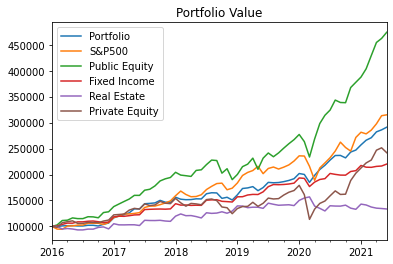

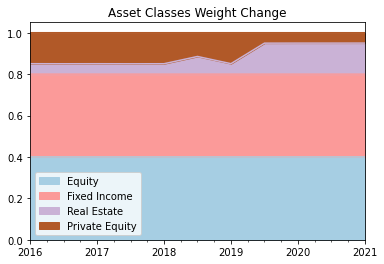

In [3]:
'----------------------------------Input Setup-----------------------------------'
tk_Input=tk.Tk()
tk_Input.title('Input File Path')
tk_Input.eval('tk::PlaceWindow . center')

image1 = tk.PhotoImage(file="mmf.png")
background_label = tk.Label(tk_Input, image=image1)
background_label.place(x=0, y=0, relwidth=1, relheight=1)


tk.Label(tk_Input,text='File Path',font='Helvetica 12 bold').grid(row=0,column=1)

myFont = Font(family="Times New Roman", size=11)

tk.Label(tk_Input,text='Public Equity',font='Helvetica 12 bold').grid(row=1,column=0)
PublicEquity_path = tk.Entry(tk_Input)
PublicEquity_path.insert(0,"Equity.xlsx")
PublicEquity_path.configure(font=myFont)
PublicEquity_path.grid(row=1,column=1,columnspan=4)

tk.Label(tk_Input,text='Fixed Income',font='Helvetica 12 bold').grid(row=2,column=0)
FixedIncome_path = tk.Entry(tk_Input)
FixedIncome_path.insert(0,"Fixed Income.xlsx")
FixedIncome_path.configure(font=myFont)
FixedIncome_path.grid(row=2,column=1,columnspan=4)

tk.Label(tk_Input,text='Private Equity',font='Helvetica 12 bold').grid(row=3,column=0)
PE_Path = tk.Entry(tk_Input)
PE_Path.insert(0,"Private Equity.xlsx")
PE_Path.configure(font=myFont)
PE_Path.grid(row=3,column=1,columnspan=4)


tk.Label(tk_Input,text='Real Estate',font='Helvetica 12 bold').grid(row=4,column=0)
REst_Path = tk.Entry(tk_Input)
REst_Path.insert(0,"Real Estate.xlsx")
REst_Path.configure(font=myFont)
REst_Path.grid(row=4,column=1,columnspan=4)

def getInput (curr_windo):
    Pub_Path = PublicEquity_path.get()
    FI_Path = FixedIncome_path.get()
    Pri_Path = PE_Path.get()
    R_Path = REst_Path.get()
    global params
    params = [Pub_Path, FI_Path, Pri_Path, R_Path]
    curr_windo.destroy()

Button=tk.Button(tk_Input,text='Continue',command= lambda:getInput(tk_Input))
Button.grid(row=12,column=0,columnspan=3)
tk_Input.mainloop()

'----------------------------------Data Import Setup-----------------------------------'
pe_data = params[2]
real_estate_data = params[3]
fi_data = params[1]
eq_data = params[0]

# Import data
# Macroeconomics factors:
mac_factor,mac_factor_re=read_file('Macro Factor.xlsx')
# F-F 5 factors model from Kenneth R. French Library:
stock_factor=pd.read_excel('Stock Factor.xlsx')
stock_factor['Date']=pd.to_datetime(stock_factor['Date'])
stock_factor=stock_factor.set_index('Date').sort_index(ascending=True).dropna()
# S&P 500 used as Benchmark:
SPX,SPXRe=read_file('S&P500.xlsx')
# Four asset classes
PE,PE_re=read_file(pe_data)
RealEst,RealEst_re=read_file(real_estate_data)
FI,FI_re=read_file(fi_data)
Equity,Equity_re=read_file(eq_data)

RF=pd.read_excel('Risk Free.xlsx')
RF['Date']=pd.to_datetime(RF['Date'])
RF=RF.set_index('Date').sort_index(ascending=True).dropna()

equity_drop = pd.read_excel('Scenario Input.xlsx', sheet_name = 'GFCreturn',index_col=0).T
date=list(Equity.index)
index=list(range(len(date)))
date_index=dict(zip(date,index))
index_date=dict(zip(index,date))

initial_invest=100000

# Start date
invest_start=pd.to_datetime('2016-01-01')
invest_start=date_index[invest_start]

'-------------------------------------Functions-------------------------------------'
# When select portfolio optimization using maximum Sharpe Ratio
def max_sharpe(invest_start,combobox,checkbox):
    checkbox=float(checkbox)
    if combobox=='3m':
        rebalance=3
    elif combobox=='6m':
        rebalance=6
    elif combobox=='12m':
        rebalance=12
    else:
        tkinter.messagebox.showwarning(title='Warning', message='Invalid Frequency!' )
    show_result(0,1,invest_start,rebalance,checkbox)

# When select portfolio optimization using expected return:
def expected_ret(inputRe,invest_start,combobox,checkbox):
    # checkbox indicates that if there is 10k injection every 6 months
    checkbox=float(checkbox)
    if combobox=='3m':
        rebalance=3
    elif combobox=='6m':
        rebalance=6
    elif combobox=='12m':
        rebalance=12
    else:
        tkinter.messagebox.showwarning(title='Warning', message='Invalid Frequency!' )
    
    # Automatically convert user input into a value between min and max possible returns
    inputRe_scale=(float(inputRe)-min(Initial_classRe))/(max(Initial_classRe)-min(Initial_classRe))
    if inputRe_scale>1:
        tkinter.messagebox.showwarning(title='Warning', message='Return is too high' )
    elif inputRe_scale<0:
        tkinter.messagebox.showwarning(title='Warning', message='Return is too low' )
    else:
        show_result(inputRe_scale,0,invest_start,rebalance,checkbox)    

# Get final result
def show_result(inputRe_scale,strategy,invest_start,rebalance,checkbox):
    # strategy=0: choose portfolio investment using input expected return
    # strategy=1: choose portfolio investment using maximum sharpe ratio
    rebalance_period=rebalance
    if checkbox==1:
        injection=10000
    elif checkbox==0:
        injection=0
    global scenario,portfolio_value,portfolio_w,TimeSeries,ann_return,VaR,ann_value,report
    TrainStart=0
    time0=invest_start

    # Culmulated value of four asset classes
    Equity_Value=[]
    FI_Value=[]
    Real_Value=[]
    PE_Value=[]

    # VaR
    VaR_equity=[]
    VaR_fi=[]
    VaR_real=[]
    VaR_pe=[]

    # Weight
    W1=[]
    W2=[]
    W3=[]
    W4=[]

    TimeSeries=[]

    # Scenario test: Global Financial Crisis
    scenario_gfc_equity=[]
    scenario_gfc_fi=[]
    scenario_gfc_real=[]
    scenario_gfc_pe=[]

    # Scenario Test: Sharpe interest rate increase
    scenario_ir_equity=[]
    scenario_ir_fi=[]
    scenario_ir_real=[]
    scenario_ir_pe=[]

    # If invest only in one single asset:
    Invest_spx=100000
    Invest_equity=100000
    Invest_fi=100000
    Invest_real=100000
    Invest_pe=100000
    spx_figure=[]
    equity_figure=[]
    fi_figure=[]
    real_figure=[]
    pe_figure=[]
    
    # Rebalance times:
    count=1 
    
    # Portfolio value updated everytime after rebalance
    tot_invest=initial_invest

    while invest_start<len(date):
        factor=mac_factor[TrainStart:invest_start+1]
        stock_factor1=0.01*stock_factor[TrainStart:invest_start+1]

        equityRe=Equity_re[TrainStart:invest_start]
        equityPrice=Equity[TrainStart:invest_start]

        fiRe=FI_re[TrainStart:invest_start]
        fiPrice=FI[TrainStart:invest_start]

        realRe=RealEst_re[TrainStart:invest_start]
        realPrice=RealEst[TrainStart:invest_start]

        peRe=PE_re[TrainStart:invest_start]
        pePrice=PE[TrainStart:invest_start]

        spxRe=SPXRe[TrainStart:invest_start]
        spx=SPX[TrainStart:invest_start]

        rf=float(RF.iloc[invest_start])*0.01

        # Asset classes optimization:
        PE_ExpRe=geometric_avg(peRe,1)
        RealEst_ExpRe=geometric_avg(realRe,1)
        FI_ExpRe=geometric_avg(fiRe,1)
        Equity_ExpRe=geometric_avg(equityRe,1)

        classRe=np.array([Equity_ExpRe,FI_ExpRe,RealEst_ExpRe,PE_ExpRe])
        classCov=cov_matrix(Equity_re,FI_re,RealEst_re,PE_re)

        print('Rebalance time#'+str(count))
        # Bounds for asset class optimization
        lb=0.05*np.ones([4,1])
        ub=0.4*np.ones([4,1])

        if strategy==0:
            asset_weight=portfolio_opt(classRe,classCov,lb,ub,inputRe_scale)
        elif strategy==1:
            asset_weight=max_sharpe_r(classRe,classCov,rf,lb,ub)

        # Add optimal weights:
        W1.append(float(asset_weight[0]))
        W2.append(float(asset_weight[1]))
        W3.append(float(asset_weight[2]))
        W4.append(float(asset_weight[3]))
        
        # Investment amount:
        ClassInvest=asset_weight*tot_invest

        '--------------------------------Equity----------------------------------'
        EquityInvest=ClassInvest[0]
        AssetNum=equityRe.shape[1]

        CombinedFactor=pd.concat([stock_factor1,factor],axis=1)
        
        # Fit linreg model to predict returns and covariance matrix:
        mu,Q=linreg(equityRe,CombinedFactor)
        lb=np.zeros([AssetNum,1])
        ub=0.3*np.ones([AssetNum,1])

        # We assume that if sum of predicted return of each stocks is positive, then we should invest, o/w stay with cash
        if sum(mu)>0:
            # Optimal weight
            weight=max_sharpe_r(mu,Q,rf,lb,ub)

            # Calculate VaR, if it's less than -5%, then we need to use CVaR model to replace the weight
            temp_var=var_calc(equityRe,weight)
            if temp_var<-5:
                weight=cvar_opt(equityRe,rf,0)

            VaR_equity.append(var_calc(equityRe,weight))

            # Calculate the number of stocks based on optimal weight
            equityPr=Equity.iloc[invest_start].values
            money=weight*EquityInvest
            amount=np.array([float(money[i])/float(equityPr[i]) for i in range(len(equityPr))])

            # Calculate value of investment in next 6 months after rebalance:
            for t_equity in range(rebalance_period):
                if invest_start+t_equity < len(Equity_re):
                    assetPr=Equity.iloc[invest_start+t_equity].values
                    # Get scenario test
                    scenario_gfc_equity.append(test_gfc_equity(weight,float(np.dot(amount.T,assetPr)),equity_drop))
                    scenario_ir_equity.append(test_ir_equity(equityRe,assetPr,weight,spxRe))
                    TimeSeries.append(index_date[invest_start+t_equity])
                    # Get value
                    Equity_Value.append(float(np.dot(amount.T,assetPr)))
        else:
            VaR_equity.append(0)
            for t_equity in range(rebalance_period):
                if invest_start+t_equity < len(Equity_re):
                    scenario_gfc_equity.append(0)
                    scenario_ir_equity.append(0)
                    Equity_Value.append(float(EquityInvest))
                    TimeSeries.append(index_date[invest_start+t_equity])
                    
        '--------------------------------Fixed Income------------------------------'
        FIInvest=ClassInvest[1]
        AssetNum=fiRe.shape[1]

        mu,Q=linreg(fiRe,factor)
        lb=np.zeros([AssetNum,1])
        ub=np.ones([AssetNum,1])
        if sum(mu)>0:
            weight=max_sharpe_r(mu,Q,rf,lb,ub)

            temp_var=var_calc(fiRe,weight)
            if temp_var<-5:
                weight=cvar_opt(fiRe,rf,0)
            VaR_fi.append(var_calc(fiRe,weight))

            fiPr=FI.iloc[invest_start].values
            money=weight*FIInvest
            amount=np.array([float(money[i])/float(fiPr[i]) for i in range(len(fiPr))])

            for t_fi in range(rebalance_period):
                if invest_start+t_fi < len(Equity_re):
                    assetPr=FI.iloc[invest_start+t_fi].values
                    scenario_gfc_fi.append(test_gfc_fi(weight,float(np.dot(amount.T,assetPr))))
                    scenario_ir_fi.append(test_ir_fi(fiRe,assetPr,weight,spxRe))
                    FI_Value.append(float(np.dot(amount.T,assetPr)))
        else:
            VaR_fi.append(0)
            for t_fi in range(rebalance_period):
                if invest_start+t_fi < len(Equity_re):
                    scenario_gfc_fi.append(0)
                    scenario_ir_fi.append(0)
                    FI_Value.append(float(FIInvest))
                    
        '------------------------------Real Estate---------------------------------'
        RealInvest=ClassInvest[2]
        AssetNum=realRe.shape[1]

        mu,Q=linreg(realRe,factor)
        lb=np.zeros([AssetNum,1])
        ub=np.ones([AssetNum,1])

        if sum(mu)>0:
            weight=max_sharpe_r(mu,Q,rf,lb,ub)

            temp_var=var_calc(realRe,weight)
            if temp_var<-5:
                weight=cvar_opt(realRe,rf,0)
            VaR_real.append(var_calc(realRe,weight))

            realPr=RealEst.iloc[invest_start].values
            money=weight*RealInvest
            amount=np.array([float(money[i])/float(realPr[i]) for i in range(len(realPr))])

            for t_real in range(rebalance_period):
                if invest_start+t_real < len(Equity_re):
                    assetPr=RealEst.iloc[invest_start+t_real].values
                    scenario_gfc_real.append(test_gfc_real(weight,float(np.dot(amount.T,assetPr))))
                    scenario_ir_real.append(test_ir_real(realRe,assetPr,weight,spxRe))
                    Real_Value.append(float(np.dot(amount.T,assetPr)))
        else:
            VaR_real.append(0)
            for t_real in range(rebalance_period):
                if invest_start+t_real < len(Equity_re):
                    scenario_gfc_real.append(0)
                    scenario_ir_real.append(0)
                    Real_Value.append(float(RealInvest))
                    
        '-------------------------------Private Equity-----------------------------------'
        PEInvest=ClassInvest[3]
        AssetNum=peRe.shape[1]
        weight=1

        VaR_pe.append(var_calc(peRe,weight))
        pePr=PE.iloc[invest_start].values
        money=weight*PEInvest
        amount=np.array([float(money)/float(pePr[i]) for i in range(len(pePr))])

        for t_pe in range(rebalance_period):
            if invest_start+t_pe < len(Equity_re):
                assetPr=PE.iloc[invest_start+t_pe].values
                scenario_gfc_pe.append(test_gfc_pe(weight,float(np.dot(amount.T,assetPr))))
                scenario_ir_pe.append(test_ir_pe(peRe,assetPr,spxRe))
                PE_Value.append(float(np.dot(amount.T,assetPr)))

        '-----------------------------------Comparison---------------------------------------'
        spxPr=SPX.iloc[invest_start].values
        amount_spx=np.array([float(Invest_spx)/float(spxPr[i]) for i in range(len(spxPr))])

        Bench_Equity=Equity.iloc[invest_start].values
        money=np.ones([len(Bench_Equity),1])*Invest_equity/len(Bench_Equity)
        amount_Equity=np.array([float(money[i])/float(Bench_Equity[i]) for i in range(len(Bench_Equity))])

        Bench_FI=FI.iloc[invest_start].values
        money=np.ones([len(Bench_FI),1])*Invest_fi/len(Bench_FI)
        amount_FI=np.array([float(money[i])/float(Bench_FI[i]) for i in range(len(Bench_FI))])

        Bench_Real=RealEst.iloc[invest_start].values
        money=np.ones([len(Bench_Real),1])*Invest_real/len(Bench_Real)
        amount_Real=np.array([float(money[i])/float(Bench_Real[i]) for i in range(len(Bench_Real))])

        Bench_PE=PE.iloc[invest_start].values
        amount_PE=np.array([float(Invest_pe)/float(Bench_PE[i]) for i in range(len(Bench_PE))])

        for t_bench in range(rebalance_period):
            if invest_start+t_bench < len(Equity_re):
                assetPr=SPX.iloc[invest_start+t_bench].values
                spx_figure.append(float(np.dot(amount_spx.T,assetPr)))

                assetPr=Equity.iloc[invest_start+t_bench].values
                equity_figure.append(float(np.dot(amount_Equity.T,assetPr)))

                assetPr=FI.iloc[invest_start+t_bench].values
                fi_figure.append(float(np.dot(amount_FI.T,assetPr)))

                assetPr=RealEst.iloc[invest_start+t_bench].values
                real_figure.append(float(np.dot(amount_Real.T,assetPr)))

                assetPr=PE.iloc[invest_start+t_bench].values
                pe_figure.append(float(np.dot(amount_PE.T,assetPr)))

        porValue=np.array(Equity_Value)+np.array(FI_Value)+np.array(Real_Value)+np.array(PE_Value)

        # Inject $10k every 6 months:
        if (invest_start-time0)/6 in np.arange(1,100,1):
            tot_invest=porValue[-1]+injection
            Invest_spx=spx_figure[-1]+injection
            Invest_equity=equity_figure[-1]+injection
            Invest_fi=fi_figure[-1]+injection
            Invest_real=real_figure[-1]+injection
            Invest_pe=pe_figure[-1]+injection
        else:
            tot_invest=porValue[-1]
            Invest_spx=spx_figure[-1]
            Invest_equity=equity_figure[-1]
            Invest_fi=fi_figure[-1]
            Invest_real=real_figure[-1]
            Invest_pe=pe_figure[-1]

        # Update variables:
        TrainStart=TrainStart+rebalance_period
        invest_start=invest_start+rebalance_period
        count=count+1

    '---------------------------------------Output-----------------------------------'

    # Get portfolio value and other comparable values:
    portfolio_value=np.array(Equity_Value)+np.array(FI_Value)+np.array(Real_Value)+np.array(PE_Value)
    spx_figure=np.array(spx_figure)
    portfolio_value=pd.DataFrame([portfolio_value,spx_figure,equity_figure,fi_figure,real_figure,pe_figure]).T
    portfolio_value.index=TimeSeries
    portfolio_value.columns=['Portfolio','S&P500','Public Equity','Fixed Income','Real Estate','Private Equity']

    # Return and volatility
    report=np.ones([6,2])
    report[0,0]=np.log(portfolio_value['Portfolio'].values[-1]/portfolio_value['Portfolio'].values[0])
    report[1,0]=np.log(portfolio_value['S&P500'].values[-1]/portfolio_value['Portfolio'].values[0])
    report[2,0]=np.log(portfolio_value['Public Equity'].values[-1]/portfolio_value['Portfolio'].values[0])
    report[3,0]=np.log(portfolio_value['Fixed Income'].values[-1]/portfolio_value['Portfolio'].values[0])
    report[4,0]=np.log(portfolio_value['Real Estate'].values[-1]/portfolio_value['Portfolio'].values[0])
    report[5,0]=np.log(portfolio_value['Private Equity'].values[-1]/portfolio_value['Portfolio'].values[0])

    report[0,1]=np.std(-1+portfolio_value['Portfolio'].head(len(portfolio_value)-1).values/portfolio_value['Portfolio'].tail(len(portfolio_value)-1).values)
    report[1,1]=np.std(-1+portfolio_value['S&P500'].head(len(portfolio_value)-1).values/portfolio_value['S&P500'].tail(len(portfolio_value)-1).values)
    report[2,1]=np.std(-1+portfolio_value['Public Equity'].head(len(portfolio_value)-1).values/portfolio_value['Public Equity'].tail(len(portfolio_value)-1).values)
    report[3,1]=np.std(-1+portfolio_value['Fixed Income'].head(len(portfolio_value)-1).values/portfolio_value['Fixed Income'].tail(len(portfolio_value)-1).values)
    report[4,1]=np.std(-1+portfolio_value['Real Estate'].head(len(portfolio_value)-1).values/portfolio_value['Real Estate'].tail(len(portfolio_value)-1).values)
    report[5,1]= np.std(-1+portfolio_value['Private Equity'].head(len(portfolio_value)-1).values/portfolio_value['Private Equity'].tail(len(portfolio_value)-1).values)

    report=pd.DataFrame(report,index=['Portfolio','S&P500','Public Equity','Fixed Income','Real Estate','Private Equity'],columns=['Total Return','Volatility'])
    report.to_excel('Return and Volatility of the Portfolio.xlsx')
    
    # Plot total portfolio value:
    fig1=plt.figure()
    for name in list(portfolio_value.columns):
        portfolio_value[name].plot(label=name)
    plt.title('Portfolio Value')
    plt.legend()
    
    # Plot asset class weight changes:
    portfolio_w=pd.DataFrame([W1,W2,W3,W4]).T
    portfolio_w.columns=['Equity','Fixed Income','Real Estate','Private Equity']
    portfolio_w.index=[TimeSeries[i*rebalance_period] for i in range(count-1)]
    portfolio_w.plot.area(alpha=1,colormap='Paired')
    portfolio_w.to_excel('Asset Class Weight.xlsx')
    plt.title('Asset Classes Weight Change')
    
    # Value at Risk result
    VaR=pd.DataFrame([VaR_equity,VaR_fi,VaR_real,VaR_pe]).T
    VaR.columns=['VaR (Equity)','VaR (Fixed Income)','VaR (Real Estate)','VaR (Private Equity)']
    VaR.index=[TimeSeries[i*rebalance_period] for i in range(count-1)]
    VaR.to_excel('Asset Class VaR Result.xlsx')
    
    # Scenario test result
    scenario=pd.DataFrame([np.array(scenario_gfc_equity),np.array(scenario_gfc_fi),np.array(scenario_gfc_real),
                      np.array(scenario_gfc_pe),\
                      np.array(scenario_ir_equity),np.array(scenario_ir_fi),np.array(scenario_ir_real),
                      np.array(scenario_ir_pe)]).T
    scenario.columns=['Equity (Global Financial Crisis)','Fixed Income (Global Financial Crisis)',
                 'Real Estate (Global Financial Crisis)','Private Equity (Global Financial Crisis)',
                 'Equity (Increase Interest Rate)',
                 'Fixed Income (Increase Interest Rate)','Real Estate (Increase Interest Rate)',
                 'Private Equity (Increase Interest Rate)']
    scenario.index=TimeSeries
    scenario.to_excel('Scenario Tests Result.xlsx')

    # Calculate average annual return and total return of the portfolio
    ann_value=[portfolio_value['Portfolio'].values[t*rebalance_period] for t in range(count-1)]
    ann_return=[np.log(ann_value[t+1]/ann_value[t]) for t in range(len(ann_value)-1)]
    avg_return=1
    for i in range(len(ann_return)):
        avg_return=avg_return*(ann_return[i]+1)
    avg_return=avg_return**(2/len(ann_return))-1
    tot_return=np.log(portfolio_value['Portfolio'].values[-1]/portfolio_value['Portfolio'].values[0])
    message='Portfolio average annual return is '+str(round(100*avg_return,2))+'%, and portfolio total return is '+ str(round(100*tot_return,2))+'%'
    tkinter.messagebox.showinfo(title='Investment Result', message=message)

'----------------------------Other Input---------------------------'
Start=pd.to_datetime('2015-01-01')
Start=date_index[Start]

ini_factor=mac_factor[0:Start+1]
ini_equity_ret=Equity_re[0:Start]
ini_fi_ret=FI_re[0:Start]
ini_real_estate_ret=RealEst_re[0:Start]
ini_pe_ret=PE_re[0:Start]

PE_ExpRe=arithmetric_avg(ini_pe_ret)
RealEst_ExpRe=arithmetric_avg(ini_real_estate_ret)
FI_ExpRe=arithmetric_avg(ini_fi_ret)
Equity_ExpRe=arithmetric_avg(ini_equity_ret)

Initial_classRe=np.array([Equity_ExpRe,FI_ExpRe,RealEst_ExpRe,PE_ExpRe])
Initial_classCov=cov_matrix(Equity_re,FI_re,RealEst_re,PE_re)

Equity_Var=Initial_classCov[0,0]**0.5
FI_Var=Initial_classCov[1,1]**0.5
RealEst_Var=Initial_classCov[2,2]**0.5
PE_Var=Initial_classCov[3,3]**0.5

riskfree=float(RF.iloc[invest_start])
l1=0.05
u1=0.4
l2=0.05
u2=0.4
l3=0.05
u3=0.4
l4=0.05
u4=0.4

'----------------------------------User Interface-----------------------------------'
tkMain=tk.Tk()

tkMain.title('Portfolio Investment Robo Advisor')
image2 = tk.PhotoImage(file="mmf2.png")
background_label = tk.Label(tkMain, image=image2)
background_label.place(x=170, y=50, relwidth=0.9, relheight=0.9)

name = ('Asset Class', 'Expected Return', 'Volatility')
ac = ('all','n','e')
sample_data=[('Public Equity',str(round(Equity_ExpRe-0.001,3)),str(round(Equity_Var,3))),
            ('Fixed Income',str(round(FI_ExpRe,3)),str(round(FI_Var,3))),
            ('Private Equity',str(round(PE_ExpRe,3)),str(round(PE_Var,3))),
            ('Real Estate',str(round(RealEst_ExpRe+0.001,3)),str(round(RealEst_Var,3)))
            ]

tv=ttk.Treeview(tkMain,columns=ac,show='headings',height=5)
for i in range(3):
    tv.column(ac[i],width=100,anchor='e')
    tv.heading(ac[i],text=name[i])

for i in range(4):
    tv.insert('','end',values=sample_data[i])

tv.grid(row=0, column=0,columnspan=3,rowspan=4)

checkbox=tk.IntVar()
injection=tk.Checkbutton(tkMain,text='Semi-annual injection of $10k',anchor="w",variable=checkbox,onvalue=1,offvalue=0)
injection.grid(row=0,column=4)

tk.Label(tkMain,text='Expected Annual Return',anchor="w").grid(row=1,column=4)
ExpectedReturn=tk.Entry(tkMain)
ExpectedReturn.grid(row=1,column=5)


tk.Label(tkMain,text='Rebalance Frequency',anchor="w").grid(row=2,column=4)
combobox = ttk.Combobox(tkMain, values=["3m", "6m","12m"])
combobox.current(1)
combobox.grid(row=2,column=5)


Button=tk.Button(tkMain,text='Invest base on expected return',command= lambda:expected_ret(ExpectedReturn.get(),invest_start,combobox.get(),checkbox.get()))
Button.grid(row=7,column=0,columnspan=3)
Button=tk.Button(tkMain,text='Invest base on maximum sharpe ratio',command= lambda:max_sharpe(invest_start,combobox.get(),checkbox.get()))
Button.grid(row=8,column=0,columnspan=3)

tkMain.mainloop()
